# Random Forest Prediction

In [113]:
# import packages
import pandas as pd
import os
import numpy as np
import seaborn as sns
import missingno as msno
import sklearn 
from plotnine import ggplot, aes, geom_line
import math

from sklearn.model_selection import train_test_split, GridSearchCV, KFold
from sklearn.ensemble import RandomForestRegressor
from skranger.ensemble import RangerForestRegressor

In [114]:
# Load data
trade_nodelist = pd.read_csv('../Output_datasets/Yearly_trade_data_prediction/trade_nodelist.csv')
trade_edgelist = pd.read_csv('../Output_datasets/Yearly_trade_data_prediction/trade_edgelist.csv')

In [115]:
trade_nodelist.columns

Index(['Unnamed: 0', 'year', 'gdp', 'total_population',
       'urban_population(%_of_total)', 'iso2', 'cnum', 'country', 'pays',
       'area', 'dis_int', 'landlocked', 'continent', 'citynum', 'langoff_1',
       'langoff_2', 'langoff_3', 'lang20_1', 'lang20_2', 'lang20_3',
       'lang20_4', 'lang9_1', 'lang9_2', 'lang9_3', 'lang9_4', 'colonizer1',
       'colonizer2', 'colonizer3', 'colonizer4', 'short_colonizer1',
       'short_colonizer2', 'short_colonizer3', 'iso_3', 'iso_numeric'],
      dtype='object')

In [116]:
trade_edgelist.columns

Index(['Unnamed: 0', 'Period', 'Value', 'iso_o', 'iso_d', 'contig',
       'comlang_off', 'comlang_ethno', 'colony', 'comcol', 'curcol', 'col45',
       'smctry', 'dist', 'distcap', 'distw', 'distwces'],
      dtype='object')

In [117]:
# Drop lines where the origin is the same as destination
trade_edgelist = trade_edgelist.drop(trade_edgelist[trade_edgelist["iso_o"] == trade_edgelist["iso_d"]].index)

In [118]:
# Create lagged values of trade: Predict next year using the previous year instead of current
trade_edgelist['lag_value'] = trade_edgelist.groupby(['iso_o', 'iso_d'])['Value'].shift(1)
trade_edgelist['Value'] = trade_edgelist.groupby(['iso_o', 'iso_d'])['Value'].shift(-1)

In [119]:
trade_edgelist['Value'] = trade_edgelist.groupby(['iso_o', 'iso_d'])['Value'].shift(-1)

<AxesSubplot:>

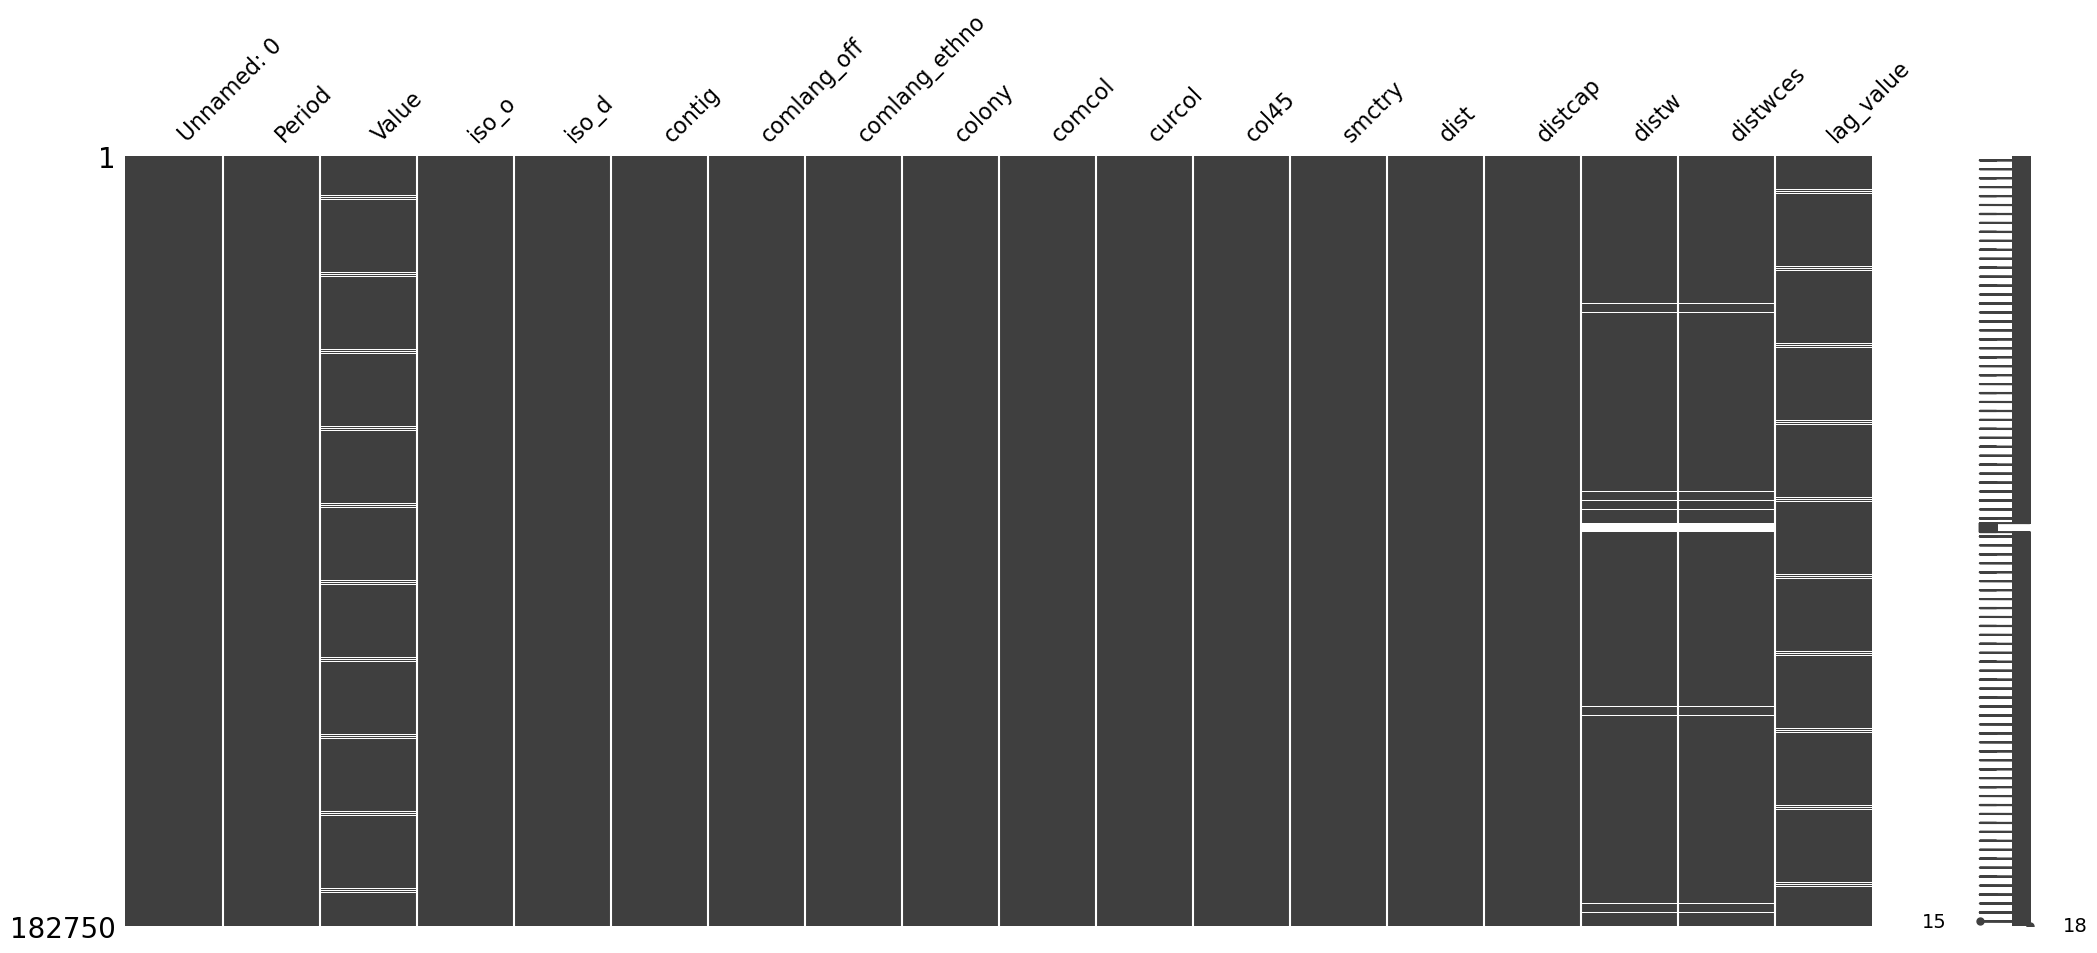

In [120]:
msno.matrix(trade_edgelist)

In [121]:
trade_edgelist

,Unnamed: 0,Period,Value,iso_o,iso_d,contig,comlang_off,comlang_ethno,colony,comcol,curcol,col45,smctry,dist,distcap,distw,distwces,lag_value
0,25,1995,96345968.0,32,36,0,0,0,0,0,0,0,0,11801.364,11733.880,12044.574134,12018.272985,NaN
1,26,1996,103474288.0,32,36,0,0,0,0,0,0,0,0,11801.364,11733.880,12044.574134,12018.272985,121775280.0
2,27,1997,101764056.0,32,36,0,0,0,0,0,0,0,0,11801.364,11733.880,12044.574134,12018.272985,96345968.0
3,28,1998,86722197.0,32,36,0,0,0,0,0,0,0,0,11801.364,11733.880,12044.574134,12018.272985,103474288.0
4,29,1999,71213431.0,32,36,0,0,0,0,0,0,0,0,11801.364,11733.880,12044.574134,12018.272985,101764056.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
182745,184870,2015,278445.0,894,858,0,0,0,0,0,0,0,0,8541.538,8541.538,8649.998621,8645.373081,284774.0
182746,184871,2016,560035.0,894,858,0,0,0,0,0,0,0,0,8541.538,8541.538,8649.998621,8645.373081,164038.0
182747,184872,2017,178133.0,894,858,0,0,0,0,0,0,0,0,8541.538,8541.538,8649.998621,8645.373081,278445.0
182748,184873,2018,508299.0,894,858,0,0,0,0,0,0,0,0,8541.538,8541.538,8649.998621,8645.373081,560035.0


<AxesSubplot:>

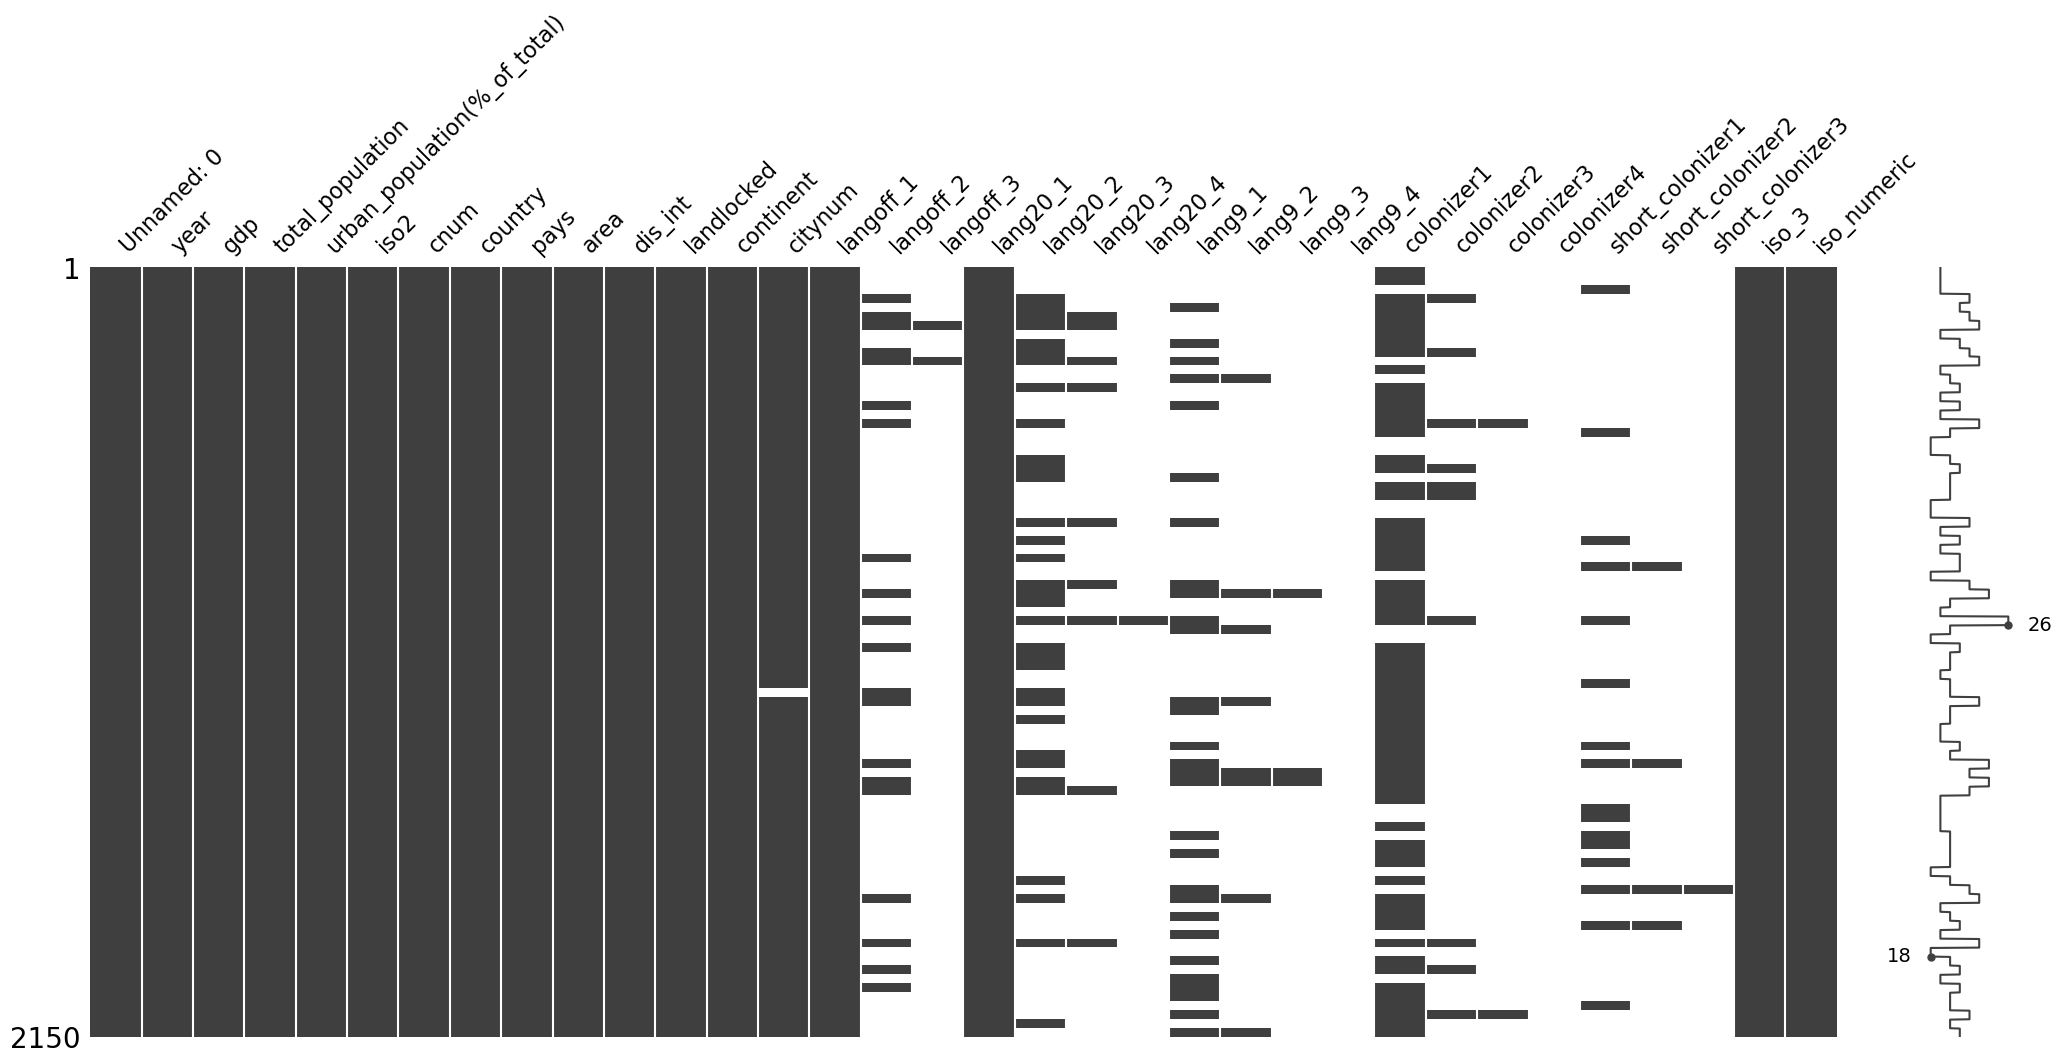

In [122]:
# Before merging, let's look at missings in the nodelist 

msno.matrix(trade_nodelist)

In [123]:
# Drop variables missing too many observations
trade_nodelist.drop(['langoff_2', 'langoff_3', 'pays', 'lang20_1', 'lang20_2', 'lang20_3', 'lang20_4', 'lang9_1', 'lang9_2',
       'lang9_3', 'lang9_4', 'colonizer1', 'colonizer2', 'colonizer3',
       'colonizer4', 'short_colonizer1', 'short_colonizer2',
       'short_colonizer3'], axis=1, inplace=True)

In [124]:
print(trade_nodelist.dtypes)

Unnamed: 0                        int64
year                              int64
gdp                             float64
total_population                float64
urban_population(%_of_total)    float64
iso2                             object
cnum                              int64
country                          object
area                              int64
dis_int                         float64
landlocked                      float64
continent                        object
citynum                         float64
langoff_1                        object
iso_3                            object
iso_numeric                       int64
dtype: object


In [125]:
# Merge once for origin and once for destination 
trade=pd.merge(trade_edgelist,trade_nodelist,how='left', left_on=['iso_o','Period'], right_on=['iso_numeric','year'],suffixes=('', '_o'))
trade=pd.merge(trade,trade_nodelist,how='left', left_on=['iso_d','Period'], right_on=['iso_numeric','year'],suffixes=('', '_d'))
trade

,Unnamed: 0,Period,Value,iso_o,iso_d,contig,comlang_off,comlang_ethno,colony,comcol,...,cnum_d,country_d,area_d,dis_int_d,landlocked_d,continent_d,citynum_d,langoff_1_d,iso_3_d,iso_numeric_d
0,25,1995,96345968.0,32,36,0,0,0,0,0,...,36,Australia,7686848,1042.81670,0.0,Pacific,25.0,English,AUS,36
1,26,1996,103474288.0,32,36,0,0,0,0,0,...,36,Australia,7686848,1042.81670,0.0,Pacific,25.0,English,AUS,36
2,27,1997,101764056.0,32,36,0,0,0,0,0,...,36,Australia,7686848,1042.81670,0.0,Pacific,25.0,English,AUS,36
3,28,1998,86722197.0,32,36,0,0,0,0,0,...,36,Australia,7686848,1042.81670,0.0,Pacific,25.0,English,AUS,36
4,29,1999,71213431.0,32,36,0,0,0,0,0,...,36,Australia,7686848,1042.81670,0.0,Pacific,25.0,English,AUS,36
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
182745,184870,2015,278445.0,894,858,0,0,0,0,0,...,858,Uruguay,176215,157.89023,0.0,America,25.0,Spanish,URY,858
182746,184871,2016,560035.0,894,858,0,0,0,0,0,...,858,Uruguay,176215,157.89023,0.0,America,25.0,Spanish,URY,858
182747,184872,2017,178133.0,894,858,0,0,0,0,0,...,858,Uruguay,176215,157.89023,0.0,America,25.0,Spanish,URY,858
182748,184873,2018,508299.0,894,858,0,0,0,0,0,...,858,Uruguay,176215,157.89023,0.0,America,25.0,Spanish,URY,858


In [126]:
trade.columns

Index(['Unnamed: 0', 'Period', 'Value', 'iso_o', 'iso_d', 'contig',
       'comlang_off', 'comlang_ethno', 'colony', 'comcol', 'curcol', 'col45',
       'smctry', 'dist', 'distcap', 'distw', 'distwces', 'lag_value',
       'Unnamed: 0_o', 'year', 'gdp', 'total_population',
       'urban_population(%_of_total)', 'iso2', 'cnum', 'country', 'area',
       'dis_int', 'landlocked', 'continent', 'citynum', 'langoff_1', 'iso_3',
       'iso_numeric', 'Unnamed: 0_d', 'year_d', 'gdp_d', 'total_population_d',
       'urban_population(%_of_total)_d', 'iso2_d', 'cnum_d', 'country_d',
       'area_d', 'dis_int_d', 'landlocked_d', 'continent_d', 'citynum_d',
       'langoff_1_d', 'iso_3_d', 'iso_numeric_d'],
      dtype='object')

<AxesSubplot:>

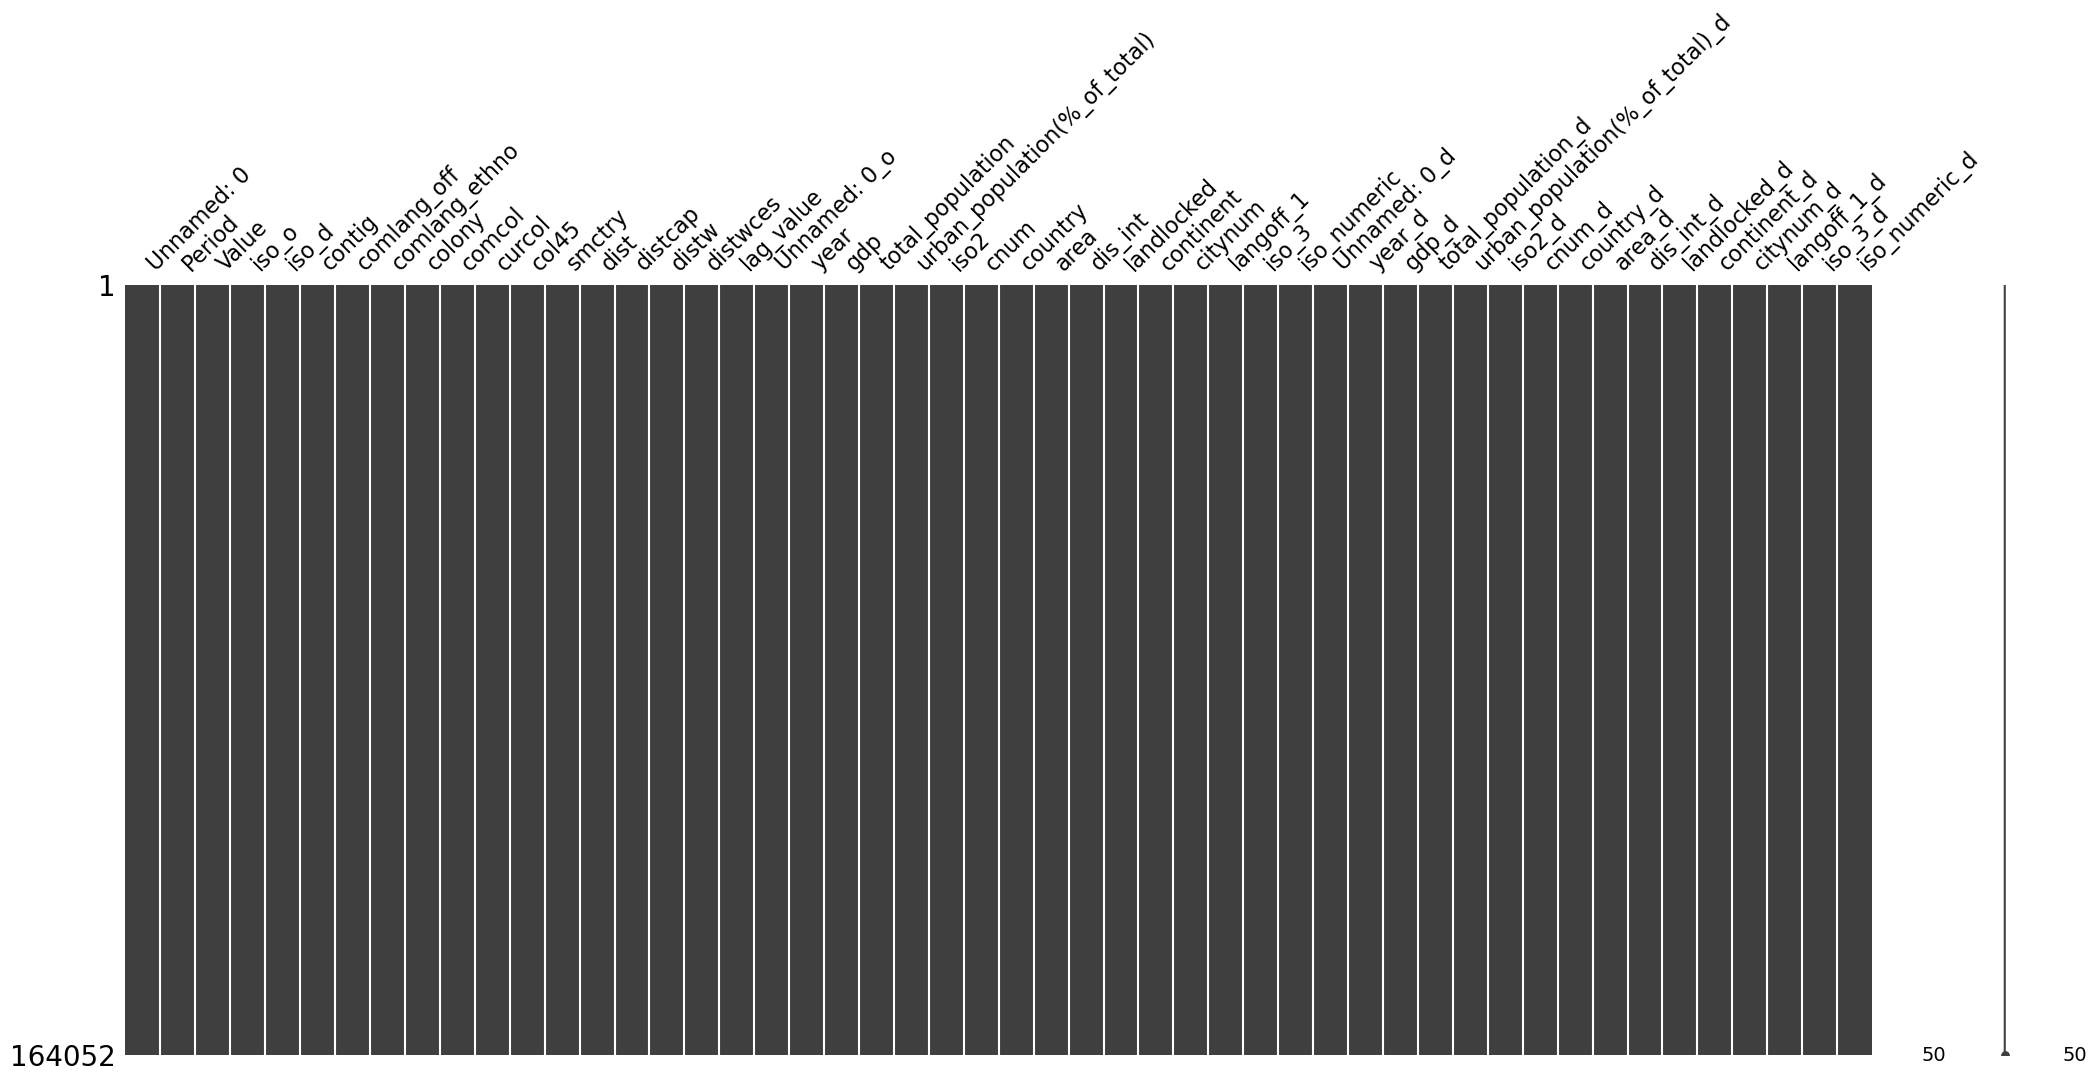

In [127]:
# Drop observations with missing data still
trade.dropna(inplace=True)
msno.matrix(trade)

In [128]:
trade

,Unnamed: 0,Period,Value,iso_o,iso_d,contig,comlang_off,comlang_ethno,colony,comcol,...,cnum_d,country_d,area_d,dis_int_d,landlocked_d,continent_d,citynum_d,langoff_1_d,iso_3_d,iso_numeric_d
1,26,1996,103474288.0,32,36,0,0,0,0,0,...,36,Australia,7686848,1042.81670,0.0,Pacific,25.0,English,AUS,36
2,27,1997,101764056.0,32,36,0,0,0,0,0,...,36,Australia,7686848,1042.81670,0.0,Pacific,25.0,English,AUS,36
3,28,1998,86722197.0,32,36,0,0,0,0,0,...,36,Australia,7686848,1042.81670,0.0,Pacific,25.0,English,AUS,36
4,29,1999,71213431.0,32,36,0,0,0,0,0,...,36,Australia,7686848,1042.81670,0.0,Pacific,25.0,English,AUS,36
5,30,2000,58609303.0,32,36,0,0,0,0,0,...,36,Australia,7686848,1042.81670,0.0,Pacific,25.0,English,AUS,36
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
182744,184869,2014,164038.0,894,858,0,0,0,0,0,...,858,Uruguay,176215,157.89023,0.0,America,25.0,Spanish,URY,858
182745,184870,2015,278445.0,894,858,0,0,0,0,0,...,858,Uruguay,176215,157.89023,0.0,America,25.0,Spanish,URY,858
182746,184871,2016,560035.0,894,858,0,0,0,0,0,...,858,Uruguay,176215,157.89023,0.0,America,25.0,Spanish,URY,858
182747,184872,2017,178133.0,894,858,0,0,0,0,0,...,858,Uruguay,176215,157.89023,0.0,America,25.0,Spanish,URY,858


In [129]:
data = trade[["Period", "Value", "iso_o", "iso_d", "contig", "comlang_off", "comlang_ethno", "colony", "comcol", "curcol", "col45", "smctry", "dist", "distcap",'distcap', 'distw', 'distwces',
       'year', 'gdp', 'total_population', 'urban_population(%_of_total)',
       'area', 'dis_int', 'landlocked',
       'citynum', 'gdp_d', 'total_population_d',
       'urban_population(%_of_total)_d', 'cnum_d',
       'area_d', 'dis_int_d', 'landlocked_d', 'citynum_d', 'lag_value']]
data_train = data[(data["Period"] >= 1995) & (data["Period"] <= 1999)]
data_test = data[(data["Period"] == 2000)]
X_train= data_train.drop(['Value'], axis=1)
X_test= data_test.drop(['Value'], axis=1)
y_train = data_train['Value']
y_test = data_test['Value']

In [130]:
data

,Period,Value,iso_o,iso_d,contig,comlang_off,comlang_ethno,colony,comcol,curcol,...,citynum,gdp_d,total_population_d,urban_population(%_of_total)_d,cnum_d,area_d,dis_int_d,landlocked_d,citynum_d,lag_value
1,1996,103474288.0,32,36,0,0,0,0,0,0,...,25.0,7.366822e+11,18224767.0,84.767,36,7686848,1042.81670,0.0,25.0,121775280.0
2,1997,101764056.0,32,36,0,0,0,0,0,0,...,25.0,7.655074e+11,18423037.0,84.636,36,7686848,1042.81670,0.0,25.0,96345968.0
3,1998,86722197.0,32,36,0,0,0,0,0,0,...,25.0,8.008230e+11,18607584.0,84.503,36,7686848,1042.81670,0.0,25.0,103474288.0
4,1999,71213431.0,32,36,0,0,0,0,0,0,...,25.0,8.405144e+11,18812264.0,84.370,36,7686848,1042.81670,0.0,25.0,101764056.0
5,2000,58609303.0,32,36,0,0,0,0,0,0,...,25.0,8.733043e+11,19028802.0,84.235,36,7686848,1042.81670,0.0,25.0,86722197.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
182744,2014,164038.0,894,858,0,0,0,0,0,0,...,25.0,5.307752e+10,3391662.0,94.945,858,176215,157.89023,0.0,25.0,220510.0
182745,2015,278445.0,894,858,0,0,0,0,0,0,...,25.0,5.327430e+10,3402818.0,95.045,858,176215,157.89023,0.0,25.0,284774.0
182746,2016,560035.0,894,858,0,0,0,0,0,0,...,25.0,5.417453e+10,3413766.0,95.144,858,176215,157.89023,0.0,25.0,164038.0
182747,2017,178133.0,894,858,0,0,0,0,0,0,...,25.0,5.505636e+10,3422200.0,95.240,858,176215,157.89023,0.0,25.0,278445.0


In [131]:
print(data.dtypes)


Period                              int64
Value                             float64
iso_o                               int64
iso_d                               int64
contig                              int64
comlang_off                         int64
comlang_ethno                       int64
colony                              int64
comcol                              int64
curcol                              int64
col45                               int64
smctry                              int64
dist                              float64
distcap                           float64
distcap                           float64
distw                             float64
distwces                          float64
year                                int64
gdp                               float64
total_population                  float64
urban_population(%_of_total)      float64
area                                int64
dis_int                           float64
landlocked                        

In [133]:
# Train using 5 years and predict one year plus grid search

#regr = RandomForestRegressor(max_depth=5, random_state=42, n_jobs = -1)
regr = RangerForestRegressor(importance="impurity",max_depth=5, seed=42, n_jobs = -1, mtry= 20, min_node_size= 4)

tune_grid = {"mtry": [8, 10, 12], "min_node_size": [5, 10, 15]}

rf_random = GridSearchCV(
    regr,
    tune_grid,
    cv=5,
    scoring="neg_root_mean_squared_error",
    verbose=3,
)

trade_out = pd.DataFrame()
year = 1996
print(year)
data_train = data[(data["Period"] >= year) & (data["Period"] <= year + 4)]
data_test = data[(data["Period"] == year + 5)]
X_train= data_train.drop(['Value'], axis=1)
X_test= data_test.drop(['Value'], axis=1)
y_train = data_train['Value']
y_test = data_test['Value']

regr.fit(X_train, y_train)
y_predic = regr.predict(X_test)

X_test['target'] = y_test
X_test ['prediction'] = y_predic
   
trade_out = pd.concat([trade_out, X_test])

MSE = np.square(np.subtract(y_test,y_predic)).mean() 
 
RMSE = math.sqrt(MSE)
print("Root Mean Square Error:\n")
print(np.log(RMSE))

1996
Root Mean Square Error:

20.498454189996902


In [144]:
# Train using 5 years and predict one year plus grid search

#regr = RandomForestRegressor(max_depth=5, random_state=42, n_jobs = -1)
regr = RangerForestRegressor(importance="impurity",max_depth=5, seed=42, n_jobs = -1)

tune_grid = {"mtry": [20, 25, 30], "min_node_size": [4, 7, 10]}

rf_random = GridSearchCV(
    regr,
    tune_grid,
    cv=5,
    scoring="neg_root_mean_squared_error",
    verbose=3,
)

trade_out = pd.DataFrame()
for year in range(1996, 2014):
    print(year)
    data_train = data[(data["Period"] >= year) & (data["Period"] <= year + 4)]
    data_test = data[(data["Period"] == year + 5)]
    X_train= data_train.drop(['Value'], axis=1)
    X_test= data_test.drop(['Value'], axis=1)
    y_train = data_train['Value']
    y_test = data_test['Value']

    rf_random.fit(X_train, y_train)
    y_predic = rf_random.predict(X_test)

    X_test['target'] = y_test
    X_test ['prediction'] = y_predic
   
    trade_out = pd.concat([trade_out, X_test])
    

1996
Fitting 5 folds for each of 9 candidates, totalling 45 fits
[CV 1/5] END .min_node_size=4, mtry=20;, score=-879371472.156 total time=   0.7s
[CV 2/5] END min_node_size=4, mtry=20;, score=-1441451248.950 total time=   0.7s
[CV 3/5] END min_node_size=4, mtry=20;, score=-1006832134.544 total time=   0.7s
[CV 4/5] END .min_node_size=4, mtry=20;, score=-363240628.971 total time=   0.8s
[CV 5/5] END min_node_size=4, mtry=20;, score=-2986729826.126 total time=   0.7s
[CV 1/5] END .min_node_size=4, mtry=25;, score=-435057580.255 total time=   0.7s
[CV 2/5] END min_node_size=4, mtry=25;, score=-1299515843.544 total time=   0.7s
[CV 3/5] END min_node_size=4, mtry=25;, score=-1185757559.004 total time=   0.8s
[CV 4/5] END .min_node_size=4, mtry=25;, score=-341203043.718 total time=   0.7s
[CV 5/5] END min_node_size=4, mtry=25;, score=-2447651294.820 total time=   0.7s
[CV 1/5] END .min_node_size=4, mtry=30;, score=-563677362.842 total time=   0.7s
[CV 2/5] END min_node_size=4, mtry=30;, scor

In [145]:
trade_out

,Period,iso_o,iso_d,contig,comlang_off,comlang_ethno,colony,comcol,curcol,col45,...,total_population_d,urban_population(%_of_total)_d,cnum_d,area_d,dis_int_d,landlocked_d,citynum_d,lag_value,target,prediction
6,2001,32,36,0,0,0,0,0,0,0,...,19274701.0,84.100,36,7686848,1042.81670,0.0,25.0,7.121343e+07,4.934233e+07,3.398304e+07
31,2001,32,40,0,0,0,0,0,0,0,...,8042293.0,59.934,40,83858,108.91960,1.0,25.0,8.114909e+07,3.632679e+07,3.398304e+07
56,2001,32,68,1,1,1,0,0,0,0,...,8746084.0,62.306,68,1098581,394.23016,1.0,25.0,2.003386e+07,1.593744e+07,2.310510e+07
81,2001,32,76,1,0,0,0,0,0,0,...,178211881.0,81.553,76,8511920,1097.35610,0.0,25.0,6.478454e+09,2.518267e+09,7.163657e+09
106,2001,32,84,0,1,1,0,0,0,0,...,248100.0,45.381,84,22963,56.99649,0.0,9.0,0.000000e+00,0.000000e+00,2.310510e+07
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
182648,2018,894,826,0,1,1,1,0,0,1,...,66460344.0,83.398,826,244110,185.83461,0.0,25.0,1.417524e+08,1.306643e+08,1.873714e+08
182673,2018,894,834,1,1,0,0,1,0,0,...,58090443.0,33.776,834,945090,365.65405,0.0,25.0,1.652221e+08,2.045174e+08,8.368749e+07
182698,2018,894,840,0,1,1,0,0,0,0,...,326838199.0,82.256,842,9529106,1161.07400,0.0,25.0,1.084819e+08,1.864602e+08,2.464497e+08
182723,2018,894,854,0,0,0,0,0,0,0,...,20392723.0,29.358,854,274200,196.95523,1.0,25.0,0.000000e+00,3.978000e+03,7.009636e+07


In [146]:
# Save results
results = pd.DataFrame({
    'year': trade_out['Period'],
    'iso_o': trade_out['iso_o'],
    'iso_d': trade_out['iso_d'],
    'target': trade_out['target'],
    'prediction': trade_out['prediction']
})

results.to_csv('prediction.csv')